# [使用 LSTM 进行多变量时间序列预测的保姆级教程](https://avoid.overfit.cn/post/1a36216705f2441b80fca567ea61e365)

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [48]:
# 设置单元格多个输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 加载数据，并检查输出
* csv文件中包含了谷歌从2001-01-25到2021-09-29的股票数据，数据是按照天数频率的。

[如果您愿意，您可以将频率转换为“B”[工作日]或“D”，因为我们不会使用日期，我只是保持它的现状。]

这里我们试图预测“Open”列的未来值，因此“Open”是这里的目标列

In [45]:
df=pd.read_csv("train.csv",parse_dates=["Date"],index_col=[0])
df.shape

(5203, 5)

In [47]:
df.head()
df.tail()

,Open,High,Low,Close,Adj Close
Date,,,,,
2001-01-25,356.730774,362.980774,352.403839,353.365387,197.122452
2001-01-26,357.211548,360.096161,342.788452,343.269226,191.490234
2001-01-29,345.153839,355.769226,338.461548,341.384613,190.439011
2001-01-30,344.307678,355.923065,341.692322,355.769226,198.463318
2001-01-31,359.615387,361.153839,350.461548,353.692322,197.304749


,Open,High,Low,Close,Adj Close
Date,,,,,
2021-09-23,99.529999,104.080002,99.519997,102.959999,102.789993
2021-09-24,102.660004,104.199997,102.599998,103.800003,103.709198
2021-09-27,104.550003,106.330002,104.389999,105.349998,105.257835
2021-09-28,105.290001,106.750000,104.730003,105.730003,105.637512
2021-09-29,106.000000,107.000000,105.309998,106.279999,106.187027


## 进行训练、测试集拆分

In [40]:
test_split=round(len(df)*0.20)
test_split

1041

In [49]:
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
df_for_training.shape
df_for_testing.shape

(4162, 5)

(1041, 5)

## 数据归一化
* MinMaxScaler缩放数据

In [50]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)

In [51]:
df_for_training_scaled

array([[0.85398707, 0.86281807, 0.85292546, 0.8403402 , 0.82180889],
       [0.85533406, 0.85473269, 0.82623316, 0.8122593 , 0.79289309],
       [0.82155169, 0.84260459, 0.81422168, 0.80701755, 0.78749611],
       ...,
       [0.40689652, 0.40362224, 0.41960282, 0.40436458, 0.7632948 ],
       [0.40517242, 0.39995691, 0.41832161, 0.4075738 , 0.76889077],
       [0.40862067, 0.39974127, 0.41426436, 0.39880189, 0.75359571]])

In [52]:
df_for_training_scaled.shape
df_for_testing_scaled.shape

(4162, 5)

(1041, 5)

## 将数据拆分为X和Y

In [53]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)        

让我们看看上面的代码中做了什么：

N_past是我们在预测下一个目标值时将在过去查看的步骤数。

这里使用30，意味着将使用过去的30个值(包括目标列在内的所有特性)来预测第31个目标值。

因此，在trainX中我们会有所有的特征值，而在trainY中我们只有目标值。

让我们分解for循环的每一部分

对于训练，dataset = df_for_training_scaled, n_past=30

当i= 30:

data_X.addend (df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])

从n_past开始的范围是30，所以第一次数据范围将是-[30 - 30,30,0:5] 相当于 [0:30,0:5]

因此在dataX列表中，df_for_training_scaled[0:30,0:5]数组将第一次出现。

现在, dataY.append(df_for_training_scaled[i,0])

i = 30，所以它将只取第30行开始的open(因为在预测中，我们只需要open列，所以列范围仅为0，表示open列)。

第一次在dataY列表中存储df_for_training_scaled[30,0]值。

所以包含5列的前30行存储在dataX中，只有open列的第31行存储在dataY中。然后我们将dataX和dataY列表转换为数组，它们以数组格式在LSTM中进行训练。

In [54]:
trainX,trainY=createXY(df_for_training_scaled,30)
trainX.shape
trainY.shape

(4132, 30, 5)

(4132,)

4132 是 trainX 中可用的数组总数，每个数组共有 30 行和 5 列， 在每个数组的 trainY 中，我们都有下一个目标值来训练模型。

In [55]:
trainX[0]
trainY[0]

array([[0.85398707, 0.86281807, 0.85292546, 0.8403402 , 0.82180889],
       [0.85533406, 0.85473269, 0.82623316, 0.8122593 , 0.79289309],
       [0.82155169, 0.84260459, 0.81422168, 0.80701755, 0.78749611],
       [0.81918098, 0.84303579, 0.82319031, 0.8470261 , 0.8286929 ],
       [0.86206895, 0.85769729, 0.84753366, 0.84124952, 0.8227448 ],
       [0.85668106, 0.85295391, 0.85479397, 0.84659822, 0.82825271],
       [0.85129307, 0.85661925, 0.85372629, 0.84766796, 0.82935384],
       [0.8540948 , 0.88249248, 0.85799703, 0.88125807, 0.86394198],
       [0.88577588, 0.88227684, 0.88255396, 0.87590928, 0.85843431],
       [0.88189657, 0.87602422, 0.87016871, 0.86200256, 0.84411479],
       [0.88362063, 0.88357053, 0.87892376, 0.86606763, 0.84829995],
       [0.87047413, 0.86200956, 0.84390347, 0.8344031 , 0.81569511],
       [0.83857758, 0.87645542, 0.84966903, 0.87398378, 0.85645156],
       [0.88168102, 0.88012075, 0.88105913, 0.86649551, 0.84874037],
       [0.87090514, 0.86287196, 0.

0.8297413960482309

In [56]:
trainX[1]
trainY[1]

array([[0.85533406, 0.85473269, 0.82623316, 0.8122593 , 0.79289309],
       [0.82155169, 0.84260459, 0.81422168, 0.80701755, 0.78749611],
       [0.81918098, 0.84303579, 0.82319031, 0.8470261 , 0.8286929 ],
       [0.86206895, 0.85769729, 0.84753366, 0.84124952, 0.8227448 ],
       [0.85668106, 0.85295391, 0.85479397, 0.84659822, 0.82825271],
       [0.85129307, 0.85661925, 0.85372629, 0.84766796, 0.82935384],
       [0.8540948 , 0.88249248, 0.85799703, 0.88125807, 0.86394198],
       [0.88577588, 0.88227684, 0.88255396, 0.87590928, 0.85843431],
       [0.88189657, 0.87602422, 0.87016871, 0.86200256, 0.84411479],
       [0.88362063, 0.88357053, 0.87892376, 0.86606763, 0.84829995],
       [0.87047413, 0.86200956, 0.84390347, 0.8344031 , 0.81569511],
       [0.83857758, 0.87645542, 0.84966903, 0.87398378, 0.85645156],
       [0.88168102, 0.88012075, 0.88105913, 0.86649551, 0.84874037],
       [0.87090514, 0.86287196, 0.85949177, 0.84724008, 0.82891342],
       [0.85237065, 0.88249248, 0.

0.7812499709321126

如果查看 trainX[1] 值，会发现到它与 trainX[0] 中的数据相同（第一行除外），因为我们将看到前 30 行来预测第 31 行，在第一次预测之后它会自动移动 到第 2 行并取下一个 30 值来预测下一个目标值。

让我们用一种简单的格式来解释这一切——

trainX — — →trainY  
[0 : 30,0:5] → [30,0]  
[1:31, 0:5] → [31,0]  
[2:32,0:5] →[32,0]  

In [57]:
testX,testY=createXY(df_for_testing_scaled,30)
testX.shape
testY.shape

(1011, 30, 5)

(1011,)

## 训练模型
* 使用 girdsearchCV 进行一些超参数调整以找到基础模型。

### GridSearchCV
* GridSearchCV 是 scikit-learn 中用于超参数优化的强大工具，它通过网格搜索和交叉验证来寻找模型的最佳参数组合。
* 核心功能
    * 网格搜索：
        * 自动遍历用户定义的所有参数组合
        * 穷举式搜索给定的参数空间
    * 交叉验证：
        * 对每种参数组合进行K折交叉验证
        * 评估参数组合的泛化性能
* 主要参数
```python
GridSearchCV(
    estimator,          # 要调参的模型/估计器
    param_grid,         # 参数网格(字典或字典列表)
    scoring=None,       # 评估指标
    n_jobs=None,       # 并行作业数(-1使用所有CPU)
    refit=True,        # 是否用最佳参数重新拟合
    cv=None,           # 交叉验证策略
    verbose=0,         # 详细程度
    pre_dispatch='2*n_jobs',
    error_score=np.nan,
    return_train_score=False
)
```
* 工作原理
    * 根据 param_grid 生成所有可能的参数组合
    * 对每种组合：
        * 使用交叉验证训练模型
        * 计算验证集上的平均得分
    * 选择得分最高的参数组合作为最佳参数
    * (如果 refit=True) 用最佳参数在整个训练集上重新训练模型
* 输出结果分析
    * 最佳模型信息：
        * best_estimator_: 最佳参数对应的模型
        * best_params_: 最佳参数组合
        * best_score_: 最佳模型的平均交叉验证得分
    * 完整搜索记录：
        * cv_results_: 包含所有参数组合的详细测试结果
        * 可转换为DataFrame进行更方便的分析
    * 优点
        * 自动化：自动完成繁琐的参数搜索过程
        * 可靠性：通过交叉验证评估参数性能
        * 灵活性：支持自定义评分函数和交叉验证策略
        * 可重复性：记录所有尝试的参数组合和结果
    * 注意事项
        * 参数网格过大会导致计算成本高
        * 对于连续参数，可能需要先大范围粗搜，再小范围精搜
        * 可以使用 RandomizedSearchCV 替代，当参数空间很大时更高效
* GridSearchCV 是机器学习工作流中参数调优的重要工具，能显著提升模型性能。
* [sklearn中的GridSearchCV方法详解](https://www.cnblogs.com/dalege/p/14175192.html)

In [59]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [60]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1)

parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

如果你想为你的模型做更多的超参数调整，也可以添加更多的层。但是如果数据集非常大建议增加 LSTM 模型中的时期和单位。

在第一个 LSTM 层中看到输入形状为 (30,5)。它来自 trainX 形状。(trainX.shape[1],trainX.shape[2]) → (30,5)

现在让我们将模型拟合到 trainX 和 trainY 数据中。

In [61]:
grid_search = grid_search.fit(trainX,trainY, validation_data=(testX,testY))

Epoch 1/8
130/130 [==============================] - 6s 49ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 2/8
130/130 [==============================] - 5s 36ms/step - loss: 0.0012 - val_loss: 9.0601e-04
Epoch 3/8
130/130 [==============================] - 5s 37ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4/8
130/130 [==============================] - 5s 37ms/step - loss: 9.0804e-04 - val_loss: 8.0079e-04
Epoch 5/8
130/130 [==============================] - 5s 38ms/step - loss: 8.5942e-04 - val_loss: 9.9553e-04
Epoch 6/8
130/130 [==============================] - 5s 38ms/step - loss: 7.6868e-04 - val_loss: 9.4733e-04
Epoch 7/8
130/130 [==============================] - 5s 37ms/step - loss: 7.0164e-04 - val_loss: 9.0523e-04
Epoch 8/8
130/130 [==============================] - 1s 8ms/step - loss: 0.0089
Epoch 1/8
130/130 [==============================] - 7s 54ms/step - loss: 0.0085 - val_loss: 5.9935e-04
Epoch 2/8
130/130 [==============================] - 5s 41ms/step - loss: 0.0031

### 检查模型的最佳参数

In [68]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 10, 'optimizer': 'adam'}

* 将最佳模型保存在 my_model 变量中。

In [69]:
my_model=grid_search.best_estimator_.model

In [70]:
my_model

* 其他查询

In [62]:
print("最佳参数:", grid_search.best_params_)
print("最佳得分:", grid_search.best_score_)

最佳参数: {'batch_size': 20, 'epochs': 10, 'optimizer': 'adam'}
最佳得分: -0.003174197052430827


* 完整的交叉验证结果
* cv_results_ 包含所有参数组合的详细测试结果，典型的 cv_results_ DataFrame 包含以下列：
    * mean_fit_time: 平均拟合时间
    * mean_score_time: 平均评分时间
    * mean_test_score: 平均测试得分
    * param_[参数名]: 各种参数的取值
    * params: 完整的参数组合
    * rank_test_score: 按测试得分排序的排名
    * split0_test_score, split1_test_score, ...: 每个交叉验证折的得分

In [63]:
results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_optimizer,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,46.414048,0.351675,1.109864,0.009797,16,8,adam,"{'batch_size': 16, 'epochs': 8, 'optimizer': '...",-0.008890,-0.000469,-0.004679,0.004210,3
1,43.543633,0.053244,1.117882,0.019736,16,8,Adadelta,"{'batch_size': 16, 'epochs': 8, 'optimizer': '...",-0.122149,-0.029667,-0.075908,0.046241,8
2,54.451011,0.261672,1.030178,0.018657,16,10,adam,"{'batch_size': 16, 'epochs': 10, 'optimizer': ...",-0.007537,-0.000138,-0.003837,0.003699,2
3,52.616302,0.536564,1.084641,0.008760,16,10,Adadelta,"{'batch_size': 16, 'epochs': 10, 'optimizer': ...",-0.022645,-0.003101,-0.012873,0.009772,5
4,38.676844,0.791599,0.922409,0.014502,20,8,adam,"{'batch_size': 20, 'epochs': 8, 'optimizer': '...",-0.013624,-0.000188,-0.006906,0.006718,4
5,37.839067,0.422257,0.889523,0.045836,20,8,Adadelta,"{'batch_size': 20, 'epochs': 8, 'optimizer': '...",-0.130294,-0.008277,-0.069285,0.061008,6
6,47.657228,0.018644,1.027748,0.023700,20,10,adam,"{'batch_size': 20, 'epochs': 10, 'optimizer': ...",-0.006201,-0.000148,-0.003174,0.003027,1
7,46.334166,2.149322,0.980408,0.005555,20,10,Adadelta,"{'batch_size': 20, 'epochs': 10, 'optimizer': ...",-0.110695,-0.028698,-0.069696,0.040999,7


* 可视化结果

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'C value')

Text(0, 0.5, 'Mean Test Score')

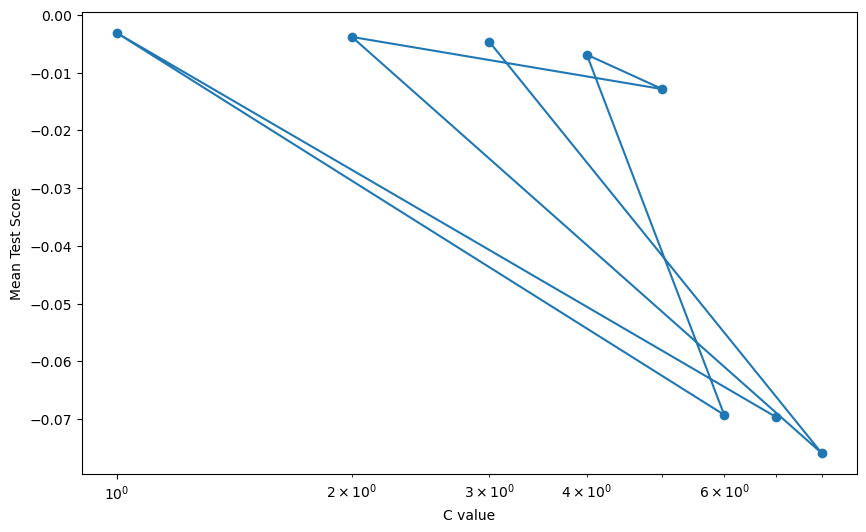

In [66]:
import matplotlib.pyplot as plt

results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
plt.plot(results['rank_test_score'], results['mean_test_score'], 'o-')
plt.xlabel('C value')
plt.ylabel('Mean Test Score')
plt.xscale('log')  # 如果C是对数分布的
plt.show()

### 用测试数据集测试模型

In [71]:
prediction=my_model.predict(testX)

In [76]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)
print("testY\n", testY)
print("\ntestYShape-",testY.shape)

prediction
 [[0.3667599 ]
 [0.3702871 ]
 [0.3733918 ]
 ...
 [0.13179763]
 [0.13430063]
 [0.13725263]]

Prediction Shape- (1011, 1)
testY
 [0.39159482 0.3965517  0.39331896 ... 0.14744613 0.1495194  0.15150862]

testYShape- (1011,)


testY 和 prediction 的长度是一样的。现在可以将 testY 与预测进行比较。

但是我们一开始就对数据进行了缩放，所以首先我们必须做一些逆缩放过程。
因为在缩放数据时，我们每行有 5 列，现在我们只有 1 列是目标列。

所以我们必须改变形状来使用 inverse_transform

In [78]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)

5 列值是相似的，它只是将单个预测列复制了 4 次。所以现在我们有 5 列相同的值 。

In [79]:
prediction_copies_array.shape

(1011, 5)

In [80]:
prediction_copies_array

array([[0.3667599 , 0.3667599 , 0.3667599 , 0.3667599 , 0.3667599 ],
       [0.3702871 , 0.3702871 , 0.3702871 , 0.3702871 , 0.3702871 ],
       [0.3733918 , 0.3733918 , 0.3733918 , 0.3733918 , 0.3733918 ],
       ...,
       [0.13179763, 0.13179763, 0.13179763, 0.13179763, 0.13179763],
       [0.13430063, 0.13430063, 0.13430063, 0.13430063, 0.13430063],
       [0.13725263, 0.13725263, 0.13725263, 0.13725263, 0.13725263]],
      dtype=float32)

In [81]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]

但是逆变换后的第一列是我们需要的，所以我们在最后使用了 → [:,0]。

现在将这个 pred 值与 testY 进行比较，但是 testY 也是按比例缩放的，也需要使用与上述相同的代码进行逆变换。

In [82]:
pred

array([182.82816 , 184.08708 , 185.19524 , ...,  98.96468 ,  99.85807 ,
       100.911705], dtype=float32)

In [83]:
original_copies_array = np.repeat(testY,5, axis=-1)

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

(5055,)

In [84]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [182.82816  184.08708  185.19524  ...  98.96468   99.85807  100.911705]

Original Values--  [191.692307 193.461533 192.307693 ... 104.550003 105.290001 106.      ]


### 最后绘制一个图来对比我们的 pred 和原始数据。

In [85]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, ' Stock Price Prediction')

Text(0.5, 0, 'Time')

Text(0, 0.5, ' Stock Price')

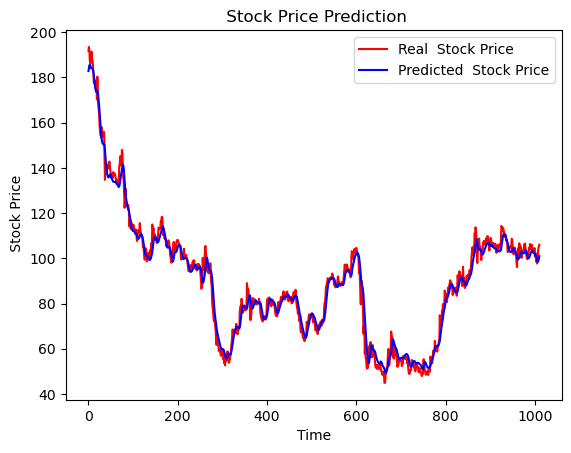

In [86]:
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

## 预测未来值
* 从主 df 数据集中获取我们在开始时加载的最后 30 个值[为什么是 30？因为这是我们想要的过去值的数量，来预测第 31 个值]

In [88]:
df_30_days_past=df.iloc[-30:,:]
df_30_days_past.tail()

,Open,High,Low,Close,Adj Close
Date,,,,,
2021-09-23,99.529999,104.080002,99.519997,102.959999,102.789993
2021-09-24,102.660004,104.199997,102.599998,103.800003,103.709198
2021-09-27,104.550003,106.330002,104.389999,105.349998,105.257835
2021-09-28,105.290001,106.750000,104.730003,105.730003,105.637512
2021-09-29,106.000000,107.000000,105.309998,106.279999,106.187027


可以看到有包括目标列（“Open”）在内的所有列。现在让我们预测未来的 30 个值。

在多元时间序列预测中，需要通过使用不同的特征来预测单列，所以在进行预测时我们需要使用特征值（目标列除外）来进行即将到来的预测。

这里我们需要“High”、“Low”、“Close”、“Adj Close”列的即将到来的 30 个值来对“Open”列进行预测。

In [89]:
df_30_days_future=pd.read_csv("test.csv",parse_dates=["Date"],index_col=[0])
df_30_days_future.shape

(30, 4)

In [90]:
df_30_days_future

,High,Low,Close,Adj Close
Date,,,,
2021-09-30,107.089996,102.949997,103.029999,102.939865
2021-10-01,106.389999,103.669998,105.820000,105.727425
2021-10-04,107.080002,104.599998,104.900002,104.808235
2021-10-05,106.000000,103.750000,104.900002,104.808235
2021-10-06,104.419998,102.059998,104.330002,104.238731
2021-10-07,106.529999,104.330002,105.510002,105.417702
2021-10-08,106.220001,104.660004,104.720001,104.628387
2021-10-11,105.760002,103.970001,104.080002,103.988953
2021-10-12,104.040001,101.559998,102.720001,102.630142


剔除“Open”列后，使用模型进行预测之前还需要做以下的操作：

缩放数据，因为删除了‘Open’列，在缩放它之前，添加一个所有值都为“0”的Open列。

缩放后，将未来数据中的“Open”列值替换为“nan”

现在附加 30 天旧值和 30 天新值（其中最后 30 个“打开”值是 nan）

In [91]:
df_30_days_future["Open"]=0
df_30_days_future=df_30_days_future[["Open","High","Low","Close","Adj Close"]]
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [92]:
full_df.shape
full_df.tail()

(60, 5)

,0,1,2,3,4
55,NaN,0.143640,0.164162,0.150135,0.349458
56,NaN,0.152749,0.171268,0.159953,0.367565
57,NaN,0.154599,0.175349,0.159063,0.365924
58,NaN,0.171024,0.181345,0.167045,0.380645
59,NaN,0.161242,0.174766,0.160565,0.368694


要进行预测必须再次使用 for 循环，我们在拆分 trainX 和 trainY 中的数据时所做的。但是这次我们只有 X，没有 Y 值

In [93]:
full_df_scaled_array=full_df.values

In [94]:
full_df_scaled_array.shape

(60, 5)

In [95]:
all_data=[]
time_step=30
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step:i,0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

In [96]:
all_data

[array([[0.14023124]], dtype=float32),
 array([[0.1419575]], dtype=float32),
 array([[0.14336602]], dtype=float32),
 array([[0.14437674]], dtype=float32),
 array([[0.14490917]], dtype=float32),
 array([[0.14476171]], dtype=float32),
 array([[0.14482723]], dtype=float32),
 array([[0.14481631]], dtype=float32),
 array([[0.14455676]], dtype=float32),
 array([[0.1436392]], dtype=float32),
 array([[0.14232466]], dtype=float32),
 array([[0.14114404]], dtype=float32),
 array([[0.14074759]], dtype=float32),
 array([[0.14059792]], dtype=float32),
 array([[0.1407732]], dtype=float32),
 array([[0.14144544]], dtype=float32),
 array([[0.14173436]], dtype=float32),
 array([[0.14177807]], dtype=float32),
 array([[0.14211234]], dtype=float32),
 array([[0.14355302]], dtype=float32),
 array([[0.14435941]], dtype=float32),
 array([[0.14472127]], dtype=float32),
 array([[0.14476873]], dtype=float32),
 array([[0.14511383]], dtype=float32),
 array([[0.14567792]], dtype=float32),
 array([[0.14602959]], dtype

对于第一个预测，有之前的 30 个值，当 for 循环第一次运行时它会检查前 30 个值并预测第 31 个“Open”数据。

当第二个 for 循环将尝试运行时，它将跳过第一行并尝试获取下 30 个值 [1:31] 。这里会报错错误因为Open列最后一行是 “nan”，所以需要每次都用预测替换“nan”。

最后还需要对预测进行逆变换→

In [97]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,0]

In [98]:
y_pred_future_30_days

array([101.97484 , 102.59098 , 103.09371 , 103.45446 , 103.64451 ,
       103.59187 , 103.61526 , 103.61136 , 103.51872 , 103.19122 ,
       102.72203 , 102.300644, 102.159134, 102.10572 , 102.16828 ,
       102.40822 , 102.511345, 102.52694 , 102.646255, 103.16046 ,
       103.44828 , 103.57744 , 103.594376, 103.71755 , 103.91889 ,
       104.04441 , 104.0535  , 104.40721 , 104.91899 , 105.89783 ],
      dtype=float32)

# END!!!!